In [1]:
import pandas as pd
import numpy as np

df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')

x_train = df_train.drop(['label', 'view'], axis=1).values
y_train = df_train['label'].values
train_view = df_train['view'].values

x_test = df_test.drop(['label','view'], axis=1).values
y_test = df_test['label'].values
test_view = df_test['view'].values

print(f"Kích thước của train và labels {x_train.shape} {y_train.shape}")
print(f"Kích thước của test và labels {x_test.shape} {y_test.shape}")

Kích thước của train và labels (22152, 20) (22152,)
Kích thước của test và labels (14768, 20) (14768,)


## RandomForest classifier

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# phân loại bằng RandomForest
accuracy, y_pred = [], []


rf_model = RandomForestClassifier(
    n_estimators=300, max_depth=20, 
    min_samples_split=2,min_samples_leaf=1,
    max_features='sqrt',bootstrap=True
    )
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

accuracy = (accuracy_score(y_test, y_pred))
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.80%


In [6]:
# Thử nghiệm xem accuracy thay đổi như thế nào khi thay đổi số k-thành phần
k_range = list(range(1,14))
all_acc = []


for k in k_range:
    temp_x_train = x_train[:,0:k]
    temp_x_test = x_test[:,0:k]
    
    accuracy, y_pred = [], []


    rf_model = RandomForestClassifier(
        n_estimators=50, max_depth=20, 
        min_samples_split=2,min_samples_leaf=1,
        max_features='sqrt',bootstrap=True
        )
    rf_model.fit(temp_x_train, y_train)
    y_pred = rf_model.predict(temp_x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    # print(f'Accuracy: {accuracy[i] * 100:.2f}%')

    print(f'Độ chính xác với {k} thành phần: {accuracy * 100:.2f}%')
    all_acc.append(accuracy*100)

Độ chính xác với 1 thành phần: 5.93%
Độ chính xác với 2 thành phần: 12.55%
Độ chính xác với 3 thành phần: 31.87%
Độ chính xác với 4 thành phần: 45.91%
Độ chính xác với 5 thành phần: 58.13%
Độ chính xác với 6 thành phần: 66.51%
Độ chính xác với 7 thành phần: 72.51%
Độ chính xác với 8 thành phần: 76.96%
Độ chính xác với 9 thành phần: 78.47%
Độ chính xác với 10 thành phần: 81.68%
Độ chính xác với 11 thành phần: 84.18%
Độ chính xác với 12 thành phần: 85.15%
Độ chính xác với 13 thành phần: 85.69%


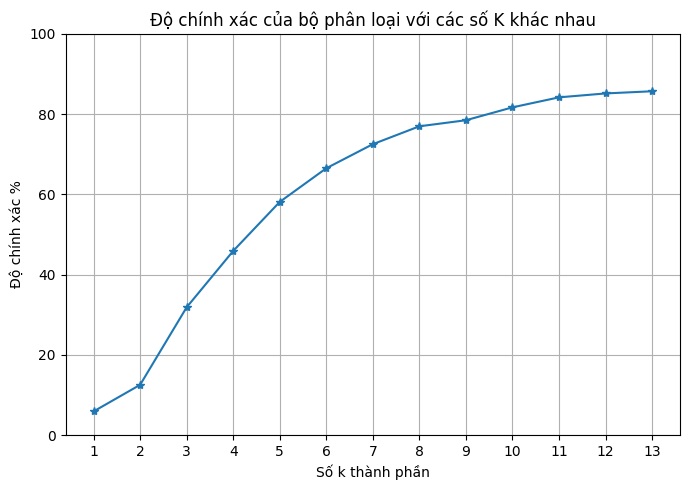

In [7]:
import matplotlib.pyplot as plt

# Tìm vị trí có độ chính xác cao nhất
# max_index = all_acc.index(max(all_acc))
# best_k = k_range[max_index]
# best_acc = all_acc[max_index]

# Làm nổi bật điểm tốt nhất
plt.figure(figsize=(7,5))
plt.title("Độ chính xác của bộ phân loại với các số K khác nhau")
plt.plot(k_range, all_acc, marker = '*', linestyle='-', linewidth = '1.5')

# plt.scatter(best_k, best_acc, color='red', s=45, label=f'Max: {best_acc:.2f} at k={best_k}')

plt.xlabel('Số k thành phần')
plt.ylabel('Độ chính xác %')
plt.xticks(k_range)
plt.ylim((0,100))
plt.grid(True)
plt.tight_layout()
plt.show()

## Confusion Matrix

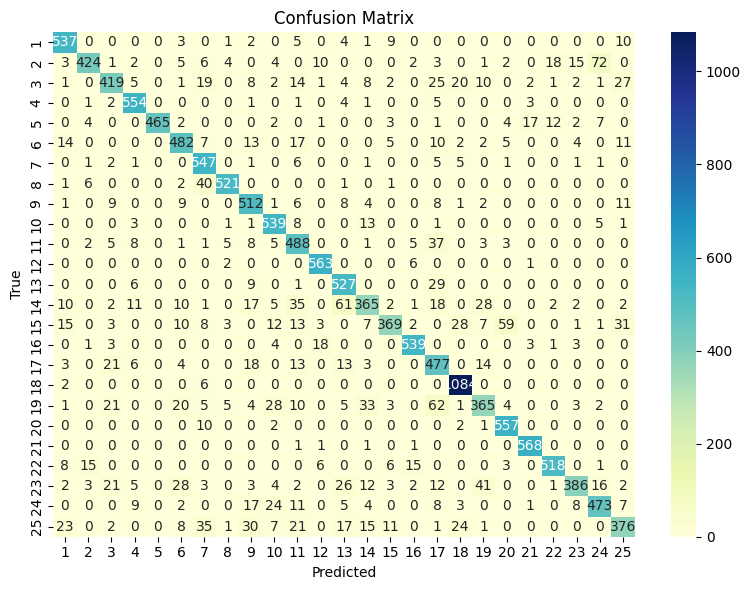

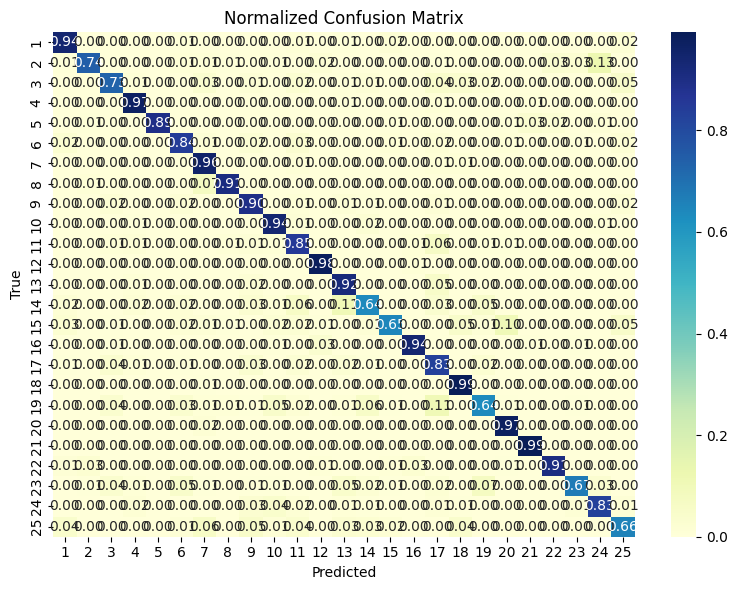

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_names = list(range(1,26))

def draw_confusion_matrix(y_test = y_test, y_pred = y_pred, class_names = class_names):
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # --- Vẽ confusion matrix gốc ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='YlGnBu',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # --- Vẽ confusion matrix đã chuẩn hóa ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
draw_confusion_matrix(y_test, y_pred, class_names) # OKE

In [12]:
# chia y_test và y_pred theo các view để visualize trên Confusion Matrix 3 chiều
views = [0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180]

# tạo 11 array để giá trị theo views
y_test_by_view = [[] for _ in range(len(views))]
y_pred_by_view = [[] for _ in range(len(views))]

# Duyệt qua tất cả giá trị với y_test và y_pred
for i in range(len(y_test)):
    if int(test_view[i]) in views:
        view_index = views.index(int(test_view[i]))
        y_test_by_view[view_index].append(y_test[i])

for i in range(len(y_pred)):
    if int(test_view[i]) in views:
        view_index = views.index(int(test_view[i]))
        y_pred_by_view[view_index].append(y_pred[i])
        
# In kiểm tra kết quả
for i in range(len(views)):
    print(f"[y_test] Góc {views[i]}° có {len(y_test_by_view[i])} mẫu")
    
for i in range(len(views)):
    print(f"[y_pred] Góc {views[i]}° có {len(y_pred_by_view[i])} mẫu dự đoán")

[y_test] Góc 0° có 1248 mẫu
[y_test] Góc 18° có 1820 mẫu
[y_test] Góc 36° có 1300 mẫu
[y_test] Góc 54° có 1300 mẫu
[y_test] Góc 72° có 1300 mẫu
[y_test] Góc 90° có 1300 mẫu
[y_test] Góc 108° có 1300 mẫu
[y_test] Góc 126° có 1300 mẫu
[y_test] Góc 144° có 1300 mẫu
[y_test] Góc 162° có 1300 mẫu
[y_test] Góc 180° có 1300 mẫu
[y_pred] Góc 0° có 1248 mẫu dự đoán
[y_pred] Góc 18° có 1820 mẫu dự đoán
[y_pred] Góc 36° có 1300 mẫu dự đoán
[y_pred] Góc 54° có 1300 mẫu dự đoán
[y_pred] Góc 72° có 1300 mẫu dự đoán
[y_pred] Góc 90° có 1300 mẫu dự đoán
[y_pred] Góc 108° có 1300 mẫu dự đoán
[y_pred] Góc 126° có 1300 mẫu dự đoán
[y_pred] Góc 144° có 1300 mẫu dự đoán
[y_pred] Góc 162° có 1300 mẫu dự đoán
[y_pred] Góc 180° có 1300 mẫu dự đoán


C:\Users\HUY\AppData\Local\Temp\ipykernel_17328\4194791873.py:20: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


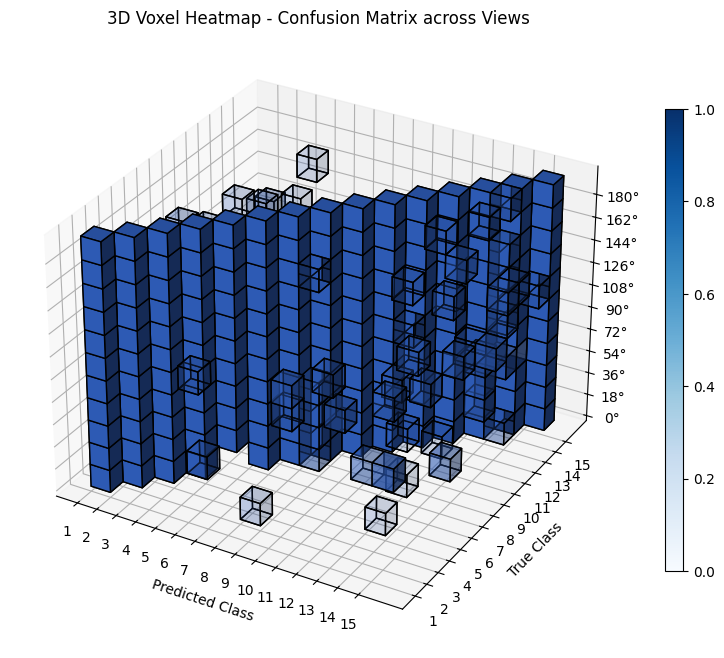

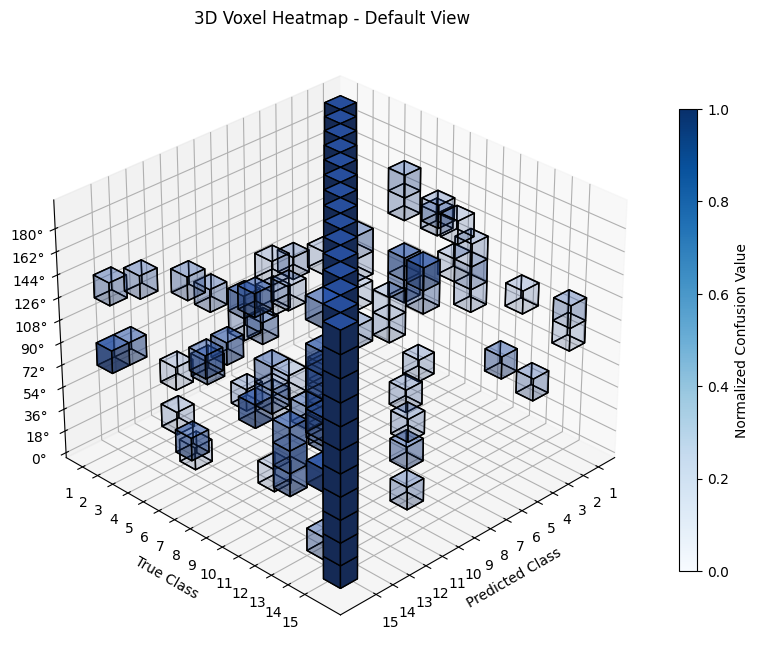

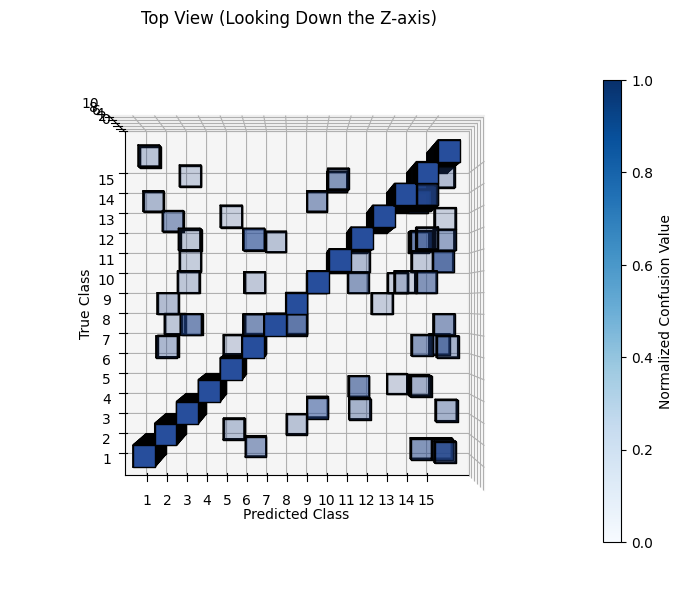

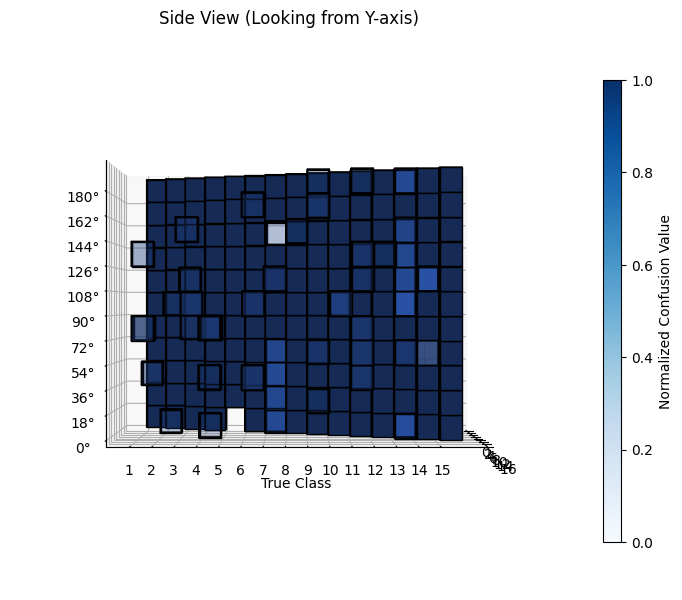

In [19]:
import matplotlib as mpl

def heatmap_3d(y_test_by_view, y_pred_by_view):
    # Tạo dữ liệu giả
    class_names = list(range(1, 16))  # 10 đối tượng
    views = [0, 18, 36, 54, 72,90, 108, 126, 144, 162, 180] # 11 hướng đi
    
    # Kích thước của voxel grid
    n_class, n_view = len(class_names), len(views)

    # Tạo lưới voxel: shape (true, pred, view)
    voxel_data = np.zeros((n_class, n_class, n_view))
    colors = np.empty(voxel_data.shape + (4,), dtype=np.float32)  # RGBA

    # Lấp dữ liệu confusion matrix vào voxel
    for v_idx, view in enumerate(views):
        # cm = confusion_matrix(y_test_all[v_idx], y_pred_all[v_idx], labels=class_names)
        cm = confusion_matrix(y_test_by_view[v_idx], y_pred_by_view[v_idx], labels=class_names)
        
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

        for i in range(n_class):        # true class
            for j in range(n_class):    # predicted class
                value = cm_norm[i, j]
                voxel_data[i, j, v_idx] = value > 0.05  # chỉ hiện khối nếu đủ lớn
                alpha = min(value * 2, 1.0)
                colors[i, j, v_idx] = [0.2, 0.4, 0.8, alpha]  # xanh lam với độ trong suốt

    # Vẽ voxel heatmapheatmap
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Confusion Matrix across Views')

    # Tạo colorbar và sử dụng color bar cho độ trong suốt (alpha value)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])  # Cần thiết để colorbar hoạt động
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25)

    plt.show()
    
    # Đồ thị góc chính diện
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('3D Voxel Heatmap - Default View')
    ax.view_init(elev=30, azim=45)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ trên cao xuống
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_xticks(np.arange(n_class))
    ax.set_xticklabels(class_names)
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_title('Top View (Looking Down the Z-axis)')
    ax.view_init(elev=90, azim=-90)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

    # Đồ thị nhìn từ bên hông qua
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel_data, facecolors=colors, edgecolor='k')

    ax.set_ylabel('True Class')
    ax.set_yticks(np.arange(n_class))
    ax.set_yticklabels(class_names)
    ax.set_zticks(np.arange(n_view))
    ax.set_zticklabels([f'{v}°' for v in views])
    ax.set_title('Side View (Looking from Y-axis)')
    ax.view_init(elev=0, azim=0)

    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.75, aspect=25, label='Normalized Confusion Value')

    plt.show()

heatmap_3d(y_test_by_view, y_pred_by_view)